I see from https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-08-15 that  sequence numbers 68-79,  `science_program` set to `BLOCK-85` contain the data. 

Either obtain the seqNums from the EFD, or from the butler registry. 

In [1]:
from astropy.time import Time, TimeDelta
import pandas as pd
from lsst_efd_client import EfdClient
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
efd_client = EfdClient('usdf_efd')
day_obs = '20230815'
butler = dafButler.Butler('/sdf/data/rubin/repo/embargo/')
datasetRefs = butler.registry.queryDatasets('raw',collections='LATISS/raw/all',
                              where=f"instrument='LATISS' AND exposure.day_obs = {day_obs}").expanded()

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


In [3]:
spans = []
intra_times = {}
extra_times = {}
for i, ref in enumerate(datasetRefs):
    record = ref.dataId.records["exposure"]
    if record.science_program =='BLOCK-85':
        print(i,record.dataId['exposure'])
        spans.append(record.timespan)
        if record.observation_reason.startswith('intra'):
            intra_times[record.seq_num] = record.timespan
            
        elif record.observation_reason.startswith('extra'):
            extra_times[record.seq_num] = record.timespan

64 2023081500068
65 2023081500071
66 2023081500074
67 2023081500077
81 2023081500070
82 2023081500073
83 2023081500076
84 2023081500079
96 2023081500069
97 2023081500072
98 2023081500075
99 2023081500078


In [5]:
intra_times

{68: Timespan(begin=astropy.time.Time('2023-08-16 00:02:47.963000', scale='tai', format='iso'), end=astropy.time.Time('2023-08-16 00:03:18.207000', scale='tai', format='iso')),
 74: Timespan(begin=astropy.time.Time('2023-08-16 00:07:34.148009', scale='tai', format='iso'), end=astropy.time.Time('2023-08-16 00:08:04.387000', scale='tai', format='iso')),
 70: Timespan(begin=astropy.time.Time('2023-08-16 00:04:31.292996', scale='tai', format='iso'), end=astropy.time.Time('2023-08-16 00:05:01.539000', scale='tai', format='iso')),
 76: Timespan(begin=astropy.time.Time('2023-08-16 00:09:04.639009', scale='tai', format='iso'), end=astropy.time.Time('2023-08-16 00:09:34.881000', scale='tai', format='iso')),
 72: Timespan(begin=astropy.time.Time('2023-08-16 00:06:02.926014', scale='tai', format='iso'), end=astropy.time.Time('2023-08-16 00:06:33.162000', scale='tai', format='iso')),
 78: Timespan(begin=astropy.time.Time('2023-08-16 00:10:35.232000', scale='tai', format='iso'), end=astropy.time.Ti

The only problem with these times is that they're in TAI - pull the end readout from the `end_readout`, as then it's in UTC. 

Get the minimum and maximum obs time for the EFD query. This will yield the CWFS results as the algorithm was run :

In [15]:
t1 = spans[0].begin.utc # need to use UTC scale 
t2 = spans[-1].end.utc

In [6]:
end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                          '*', t1, t2)

In [16]:
log = await efd_client.select_time_series("lsst.sal.Script.logevent_logMessage",
                                     ["message", "salIndex"], t1,t2    )

I use the fact that the images are all ordered as intra/extra pairs. So the i-th is intra, and i+1 is extra. Print the `additionalValues` for these to confuirm that : 

In [101]:
end_readout

,additionalKeys,additionalValues,imageController,imageDate,imageIndex,imageName,imageNumber,imageSource,imagesInSequence,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,requestedExposureTime,timestampAcquisitionStart,timestampEndOfReadout
2023-08-16 00:02:43.611861+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:00\:07.273:CWFS:0:0:0.0:IN...,O,20230815,1,AT_O_20230815_000068,68,AT,1,1.692144e+09,ATCamera,1.692144e+09,37488036,1.692144e+09,bf54d117,6266,1.692144e+09,30,1.692142e+09,1.692144e+09
2023-08-16 00:03:21.077946+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:00\:07.273:CWFS:0:0:0.0:EX...,O,20230815,1,AT_O_20230815_000069,69,AT,1,1.692144e+09,ATCamera,1.692144e+09,37488036,1.692144e+09,bf54d117,6267,1.692144e+09,30,1.692144e+09,1.692144e+09
2023-08-16 00:04:26.945414+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:04\:04.999:CWFS:0:0:0.0:IN...,O,20230815,1,AT_O_20230815_000070,70,AT,1,1.692144e+09,ATCamera,1.692144e+09,37488036,1.692144e+09,bf54d117,6268,1.692144e+09,30,1.692144e+09,1.692144e+09
2023-08-16 00:05:04.501528+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:04\:04.999:CWFS:0:0:0.0:EX...,O,20230815,1,AT_O_20230815_000071,71,AT,1,1.692144e+09,ATCamera,1.692144e+09,37488036,1.692144e+09,bf54d117,6269,1.692144e+09,30,1.692144e+09,1.692144e+09
2023-08-16 00:05:58.567724+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:05\:49.451:CWFS:0:0:0.0:IN...,O,20230815,1,AT_O_20230815_000072,72,AT,1,1.692144e+09,ATCamera,1.692144e+09,37488036,1.692144e+09,bf54d117,6270,1.692144e+09,30,1.692144e+09,1.692144e+09
2023-08-16 00:06:36.818443+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:05\:49.451:CWFS:0:0:0.0:EX...,O,20230815,1,AT_O_20230815_000073,73,AT,1,1.692144e+09,ATCamera,1.692144e+09,37488036,1.692144e+09,bf54d117,6271,1.692144e+09,30,1.692144e+09,1.692144e+09
2023-08-16 00:07:29.793988+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:07\:20.951:CWFS:0:0:0.0:IN...,O,20230815,1,AT_O_20230815_000074,74,AT,1,1.692144e+09,ATCamera,1.692144e+09,37488036,1.692144e+09,bf54d117,6272,1.692144e+09,30,1.692144e+09,1.692144e+09
2023-08-16 00:08:07.490279+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:07\:20.951:CWFS:0:0:0.0:EX...,O,20230815,1,AT_O_20230815_000075,75,AT,1,1.692144e+09,ATCamera,1.692145e+09,37488036,1.692145e+09,bf54d117,6273,1.692145e+09,30,1.692144e+09,1.692145e+09
2023-08-16 00:09:00.286178+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:08\:51.511:CWFS:0:0:0.0:IN...,O,20230815,1,AT_O_20230815_000076,76,AT,1,1.692145e+09,ATCamera,1.692145e+09,37488036,1.692145e+09,bf54d117,6274,1.692145e+09,30,1.692145e+09,1.692145e+09
2023-08-16 00:09:37.957885+00:00,imageType:groupId:testType:stutterRows:stutter...,CWFS:2023-08-16T00\:08\:51.511:CWFS:0:0:0.0:EX...,O,20230815,1,AT_O_20230815_000077,77,AT,1,1.692145e+09,ATCamera,1.692145e+09,37488036,1.692145e+09,bf54d117,6275,1.692145e+09,30,1.692145e+09,1.692145e+09


Find out the end of the readout time for each image in the intra/extra pair: 

In [7]:
intra_readout_times = []
extra_readout_times = []
intra_seqNum = []
extra_seqNum = []
intra_images = []
extra_images = []
i =0 
while i < len(end_readout):
#for i in range(len(end_readout)-1):
    intra = end_readout['imageName'][i]
    extra = end_readout['imageName'][i+1]
    intra_readout_times.append(end_readout.index[i])
    extra_readout_times.append(end_readout.index[i+1])
    intra_seqNum.append(end_readout['imageNumber'][i])
    extra_seqNum.append(end_readout['imageNumber'][i+1])
    intra_images.append(intra)
    extra_images.append(extra)
    print('\n',end_readout['imageNumber'][i], end_readout['additionalValues'][i].split(':')[-2],
          '&',end_readout['imageNumber'][i+1], end_readout['additionalValues'][i+1].split(':')[-2])
    print(i)
    i += 2
    
# make exposure id arrays
intra_ids = []
extra_ids = []

for i in range(len(intra_seqNum)):
    intra_ids.append(f'{day_obs}{str(intra_seqNum[i]).zfill(5)}')
    extra_ids.append(f'{day_obs}{str(extra_seqNum[i]).zfill(5)}')


 68 INTRA_SITCOM-778 & 69 EXTRA_SITCOM-778
0

 70 INTRA_SITCOM-778 & 71 EXTRA_SITCOM-778
2

 72 INTRA_SITCOM-778 & 73 EXTRA_SITCOM-778
4

 74 INTRA_SITCOM-778 & 75 EXTRA_SITCOM-778
6

 76 INTRA_SITCOM-778 & 77 EXTRA_SITCOM-778
8


In [21]:
intra_ids

['2023081500068',
 '2023081500070',
 '2023081500072',
 '2023081500074',
 '2023081500076']

Read off the rotator angle, azimuth angle, elevation angle from  the EFD:

In [8]:
from astropy.table import Table
azimuth_list = []
elevation_list = []
rot_pos_list = []
camrot_list = []

for i in range(len(intra_readout_times)):
    
    t1 = Time(intra_readout_times[i]) - TimeDelta(30, format='sec') 
    
    t2 = Time(extra_readout_times[i]) - TimeDelta(2., format='sec')

 
    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                          ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], 
                          t1, t2)
    
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                          ["nasmyth2CalculatedAngle99"], t1, t2)
    
    #camera = await efd_client.select_time_series("lsst.sal.MTRotator.rotation", 
    #                      ["actualPosition"], t1,t2 )
    
    azimuth_list.append(np.mean(azel['azimuthCalculatedAngle99']))
    elevation_list.append(np.mean(azel['elevationCalculatedAngle99']))
    rot_pos_list.append(np.mean(rotator['nasmyth2CalculatedAngle99']))
    #camrot_list.append(np.mean(camera['actualPosition']))

# store the results as astropy table 
d = Table(data=[intra_images, extra_images, rot_pos_list, elevation_list, 
                azimuth_list,],# camrot_list],
         names=['intra','extra', 'rot', 'el','az',])# 'camrot'])
d['angle'] = d['rot'] - d['el']

# need to construct 2023050900170  from AT_O_20230509_000170  et  (note 
# the EFD image ids have one zero less than the actual imageName ... )
d['intraId'] = [''.join([intra.split('_')[2], intra.split('_')[3][1:]]) for intra in d['intra']]
d['extraId'] = [''.join([extra.split('_')[2], extra.split('_')[3][1:]]) for extra in d['extra']]

Well - run the WEP pipeline as a pipetask for these pairs of exposures... 

Show the log from these times 

This is just like in the notebook `AOS_DM-38649_senM_20230510_data.ipynb` 

In [17]:
for i in range(len(log)):
    msg = log['message'][i]
    if msg.startswith('Intra/extra exposure ids'):
        print(i)
        print(msg)
        # extract the intra/extra ids from the log message 
        intraId, extraId = msg.split()[-1].split('/')
        
        # find the matching row in the EFD angles data  table 
        mask = d['intraId'] == intraId
        angle = d[mask]['angle'].data[0]
        
        print(log['message'][i+1],  'EFD(rot-el)=', angle)
    #print()

1
Intra/extra exposure ids: 2023081500068/2023081500069
Angle used in cwfs algorithm is -80.16 EFD(rot-el)= -80.1425218618271
12
Intra/extra exposure ids: 2023081500070/2023081500071
Angle used in cwfs algorithm is -95.22 EFD(rot-el)= -95.20399705003652
21
Intra/extra exposure ids: 2023081500072/2023081500073
Angle used in cwfs algorithm is -95.26 EFD(rot-el)= -95.24710072124611
30
Intra/extra exposure ids: 2023081500074/2023081500075
Angle used in cwfs algorithm is -95.30 EFD(rot-el)= -95.28556321244193
39
Intra/extra exposure ids: 2023081500076/2023081500077
Angle used in cwfs algorithm is -95.33 EFD(rot-el)= -95.31937245009355


In [53]:
for i in range(len(log)):
    print(log['message'][i])

Applying hexapod offset [m1, m2, x, y, z, u, v, w]: {'m1': 0.0, 'm2': 0.0, 'x': 0.0, 'y': 0.0, 'z': -1.6011000000000002, 'u': 0.0, 'v': 0.0}.
Intra/extra exposure ids: 2023081500068/2023081500069
Angle used in cwfs algorithm is -80.16
Applying hexapod offset [m1, m2, x, y, z, u, v, w]: {'m1': 0.0, 'm2': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.8011, 'u': 0.0, 'v': 0.0}.
Applying hexapod offset [m1, m2, x, y, z, u, v, w]: {'m1': -0.0, 'm2': 0.0, 'x': -0.0, 'y': -0.0, 'z': -0.0, 'u': -0.0, 'v': -0.0}.
Setting final state to <ScriptState.DONE: 8>
LATISS Wavefront Estimation Pipeline initialized. Perform optical Take intra and extra focal data with the Rubin Auxiliary Telescope with LATISS applying the specified degrees of freedom.
Read historical data in 0.00 sec
Setting final state to <ScriptState.DONE: 8>
Applying hexapod offset [m1, m2, x, y, z, u, v, w]: {'m1': 0.0, 'm2': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0, 'u': 0.0, 'v': 0.0}.
Applying hexapod offset [m1, m2, x, y, z, u, v, w]: {'m1': 0.0, 'm2

Show the `quickLookExp` - could I use these as input?  

In [9]:
from lsst.obs.lsst import Latiss
from astropy.visualization import ZScaleInterval

butler = dafButler.Butler('/sdf/data/rubin/repo/embargo/',
                         collections=['LATISS/raw/all', 'LATISS/calib', 'LATISS/runs/quickLook'],)
datasetRefOrType = 'quickLookExp'

i=0
expIdIntra = f'{day_obs}{str(intra_seqNum[i]).zfill(5)}'
expIdExtra = f'{day_obs}{str(extra_seqNum[i]).zfill(5)}'
    

exposure_intra = butler.get(datasetRefOrType, 
                                dataId={'instrument':'LATISS', 'detector':0, 
                                      'exposure':int(expIdIntra)}, )
    
exposure_extra = butler.get(datasetRefOrType, 
                                dataId={'instrument':'LATISS', 'detector':0, 
                                      'exposure':int(expIdExtra)}, )

In [10]:
butler = dafButler.Butler(
    '/sdf/data/rubin/repo/embargo/',
    collections=['LATISS/runs/quickLook'],
    instrument='LATISS'
)
day = 20230815
seqNum = 68
dataId = {'day_obs': day,'detector':0, 'seq_num':seqNum}
exposure = butler.get('quickLookExp', dataId=dataId, )

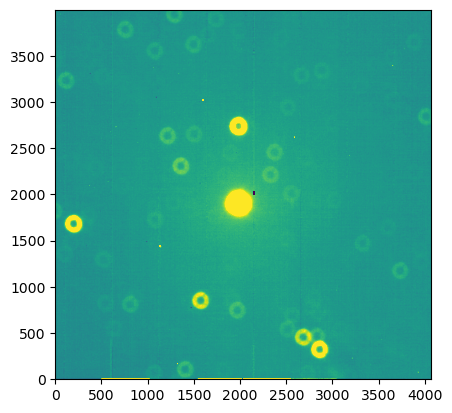

In [30]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
data = exposure_extra.image.array 
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, 
           origin='lower')

build the pipetask yaml:

In [38]:
from lsst.ts.wep.utility import getConfigDir

In [46]:
from lsst.ts.wep.utility import getModulePath

So the instrument-specific yaml is inherited by an outdated test pipeline file.  Now I update that file 

In [49]:
# this is the instrument-specific yaml, i.e. cutOutDonuts, calcZernikesTask ...
#path_to_yaml = os.path.join(getConfigDir(), 'cwfs/instData/auxTel/instParamPipeConfig.yaml')

# this is a file used to process auxTel data,
# including ISR, generateDonutDirectDetectTask, cutOutDonutsScienceSensorTask, calcZernikesTask
path_to_yaml  = os.path.join(getModulePath(), 'tests/testData/pipelineConfigs/testCalcZernikesLatissPipeline.yaml')

In [44]:
import stacking

In [12]:
from lsst.ts.wep.utility import runProgram


path_to_yaml = '/sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissPipelineUpdated.yaml'


for i in range(len(intra_seqNum)):
    expIdIntra = int(f'{day_obs}{str(intra_seqNum[i]).zfill(5)}')
    expIdExtra = int(f'{day_obs}{str(extra_seqNum[i]).zfill(5)}')

    # Run pipeline command
    expids = [expIdIntra,expIdExtra]
    instrument = "lsst.obs.lsst.Latiss"
    input_coll = "LATISS/raw/all,LATISS/calib"
    output_coll = 'u/scichris/Latiss/DM-40493'
    runName = 'u-scichris-Latiss-DM-40493-run1'

    repoDir = '/sdf/data/rubin/repo/embargo/'

    pipelineYamlPath = path_to_yaml 
    #pipelineYaml = os.path.join(
    #    os.getcwd(),'DM-37676', "testLatissPipelineISRonly.yaml"
    #)

    #expids = [2022040500795,2022040500796]
    pipetaskCmd = "pipetask run "
    pipetaskCmd += f"-b {repoDir} "  # Specify repo
    pipetaskCmd += f"-i {input_coll} "  # Specify collections with data to use
    pipetaskCmd += f" --output {output_coll} " # specify output collection 
    pipetaskCmd += f" --instrument {instrument} "
    pipetaskCmd += f" --register-dataset-types "
    pipetaskCmd += f" -p {pipelineYamlPath}" # specify yaml config file if needed 
    #pipetaskCmd += f" --output-run {runName}"
    pipetaskCmd += f" -d 'exposure IN {tuple(expids)}'"

    # Run pipeline task
    #
    print(pipetaskCmd)
    runProgram(pipetaskCmd)

pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/DM-40493  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissPipelineUpdated.yaml -d 'exposure IN (2023081500068, 2023081500069)'


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 4 tasks, graph ID: '1693250565.3595757-1969447'
Quanta             Tasks            
------ -----------------------------
     2                           isr
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500068, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500068, ...}.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter empty~empty.
lsst.isr INFO: Setting rough magnitu

pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/DM-40493  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissPipelineUpdated.yaml -d 'exposure IN (2023081500070, 2023081500071)'


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 4 tasks, graph ID: '1693250615.2860394-1969778'
Quanta             Tasks            
------ -----------------------------
     2                           isr
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500070, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500070, ...}.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter empty~empty.
lsst.isr INFO: Setting rough magnitu

pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/DM-40493  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissPipelineUpdated.yaml -d 'exposure IN (2023081500072, 2023081500073)'


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 4 tasks, graph ID: '1693250663.1081178-1970068'
Quanta             Tasks            
------ -----------------------------
     2                           isr
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500072, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500072, ...}.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter empty~empty.
lsst.isr INFO: Setting rough magnitu

pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/DM-40493  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissPipelineUpdated.yaml -d 'exposure IN (2023081500074, 2023081500075)'


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 4 tasks, graph ID: '1693250712.9822536-1970482'
Quanta             Tasks            
------ -----------------------------
     2                           isr
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500074, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500074, ...}.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter empty~empty.
lsst.isr INFO: Setting rough magnitu

pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/DM-40493  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissPipelineUpdated.yaml -d 'exposure IN (2023081500076, 2023081500077)'


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 4 tasks, graph ID: '1693250762.3011878-1970708'
Quanta             Tasks            
------ -----------------------------
     2                           isr
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500076, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=isr dataId={instrument: 'LATISS', detector: 0, exposure: 2023081500076, ...}.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter empty~empty.
lsst.isr INFO: Setting rough magnitu

Check the output of the run:

In [14]:
butler = dafButler.Butler('/sdf/data/rubin/repo/embargo/',
                         collections=[output_coll],)
datasetRefOrType = 'postISRCCD'

In [15]:
exposure_intra = butler.get(datasetRefOrType, 
                                dataId={'instrument':'LATISS', 'detector':0, 
                                      'exposure':int(expIdIntra)}, )

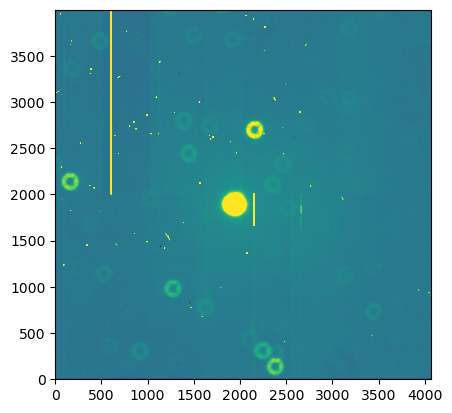

In [16]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
data = exposure_intra.image.array
vmin,vmax = zscale.get_limits(data)
plt.imshow(exposure_intra.image.array, vmin=vmin,vmax=vmax, origin='lower')

hmm, this ISR didn't address these bad columns well - what do the donut stamps look like ? 

In [17]:
butler = dafButler.Butler('/sdf/data/rubin/repo/embargo/',
                         collections=[output_coll],)
donutStampIntra = butler.get('donutStampsIntra', 
                                dataId={'instrument':'LATISS', 'detector':0, 
                                      'visit':int(expIdExtra)}, )

ok, this is because wep uses outdated ISR (probably calibs). Use the `quickLookExp` ISR instead:

In [34]:
from lsst.ts.wep.utility import runProgram


path_to_yaml = '/sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissQuickLook.yaml'


for i in range(len(intra_seqNum)):
    expIdIntra = int(f'{day_obs}{str(intra_seqNum[i]).zfill(5)}')
    expIdExtra = int(f'{day_obs}{str(extra_seqNum[i]).zfill(5)}')

    # Run pipeline command
    expids = [expIdIntra,expIdExtra]
    instrument = "lsst.obs.lsst.Latiss"
    input_coll = "LATISS/runs/quickLook"
    output_coll = 'u/scichris/Latiss/DM-40493-quickLook'
    runName = 'u-scichris-Latiss-DM-40493-run2'

    repoDir = '/sdf/data/rubin/repo/embargo/'

    pipelineYamlPath = path_to_yaml 
    #pipelineYaml = os.path.join(
    #    os.getcwd(),'DM-37676', "testLatissPipelineISRonly.yaml"
    #)

    #expids = [2022040500795,2022040500796]
    pipetaskCmd = "pipetask run "
    pipetaskCmd += f"-b {repoDir} "  # Specify repo
    pipetaskCmd += f"-i {input_coll} "  # Specify collections with data to use
    pipetaskCmd += f" --output {output_coll} " # specify output collection 
    pipetaskCmd += f" --instrument {instrument} "
    pipetaskCmd += f" --register-dataset-types "
    pipetaskCmd += f" -p {pipelineYamlPath}" # specify yaml config file if needed 
    #pipetaskCmd += f" --output-run {runName}"
    pipetaskCmd += f" -d 'exposure IN {tuple(expids)}'"

    # Run pipeline task
    #
    print(pipetaskCmd)
    #runProgram(pipetaskCmd)

pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/runs/quickLook  --output u/scichris/Latiss/DM-40493-quickLook  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissQuickLook.yaml -d 'exposure IN (2023081500068, 2023081500069)'
pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/runs/quickLook  --output u/scichris/Latiss/DM-40493-quickLook  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissQuickLook.yaml -d 'exposure IN (2023081500070, 2023081500071)'
pipetask run -b /sdf/data/rubin/repo/embargo/ -i LATISS/runs/quickLook  --output u/scichris/Latiss/DM-40493-quickLook  --instrument lsst.obs.lsst.Latiss  --register-dataset-types  -p /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-40493/testCalcZernikesLatissQuickLook.yaml -d 'exposure IN (2023081500072, 2023081500073)'
pipetask run -b /sdf/data/ru

Apply derotation to the recovered Zernikes, test if they shift in the appropriate direction:

In [36]:
butler = dafButler.Butler('/sdf/data/rubin/repo/embargo/',
                         collections=['u/scichris/Latiss/DM-40493-quickLook'],)
donutStampIntra = butler.get('donutStampsIntra', 
                             dataId={'instrument':'LATISS', 'detector':0, 
                                      'visit':2023081500069
                                    }, )

In [ ]:
plt.imshow(donutStampIntra[0].stamp_im.image.array, vmax=5600)

Read in the zernikes, apply derotation angle as above... If the angle is  correct, all should be identical 

In [24]:
zks = {}
for expId in extra_ids:
    butler = dafButler.Butler('/sdf/data/rubin/repo/embargo/',
                         collections=['u/scichris/Latiss/DM-40493-quickLook'],)

    dataId  = {'instrument':'LATISS', 'detector':0, 'visit':int(expId)}
    zk =  butler.get('zernikeEstimateRaw', dataId=dataId, )
    zks[expId] = zk

In [28]:
zk[0]

array([-0.10418725, -0.05812449, -0.0657105 , -0.01457043,  0.00278198,
       -0.02184371, -0.00147516,  0.01670686, -0.00016695,  0.00641269,
        0.01888026, -0.00131267,  0.00017671,  0.00149497,  0.00541843,
       -0.00639565,  0.00256042,  0.00825624, -0.001866  ])

In [29]:
expId

'2023081500077'

Plot the raw Zernikes:

In [31]:
d

intra,extra,rot,el,az,angle,intraId,extraId
str20,str20,float64,float64,float64,float64,str13,str13
AT_O_20230815_000068,AT_O_20230815_000069,0.23884503136774024,80.38136689319485,91.32066252445243,-80.1425218618271,2023081500068,2023081500069
AT_O_20230815_000070,AT_O_20230815_000071,-14.447712783571854,80.75628426646466,91.16361254738193,-95.20399705003652,2023081500070,2023081500071
AT_O_20230815_000072,AT_O_20230815_000073,-14.158836965996835,81.08826375524927,91.01247917264801,-95.24710072124611,2023081500072,2023081500073
AT_O_20230815_000074,AT_O_20230815_000075,-13.869004070542525,81.4165591418994,90.85894232866606,-95.28556321244193,2023081500074,2023081500075
AT_O_20230815_000076,AT_O_20230815_000077,-13.576174265535128,81.74319818455842,90.70180088816672,-95.31937245009355,2023081500076,2023081500077


Text(0.5, 1.0, 'auxTel 20230815, raw Zernikes ')

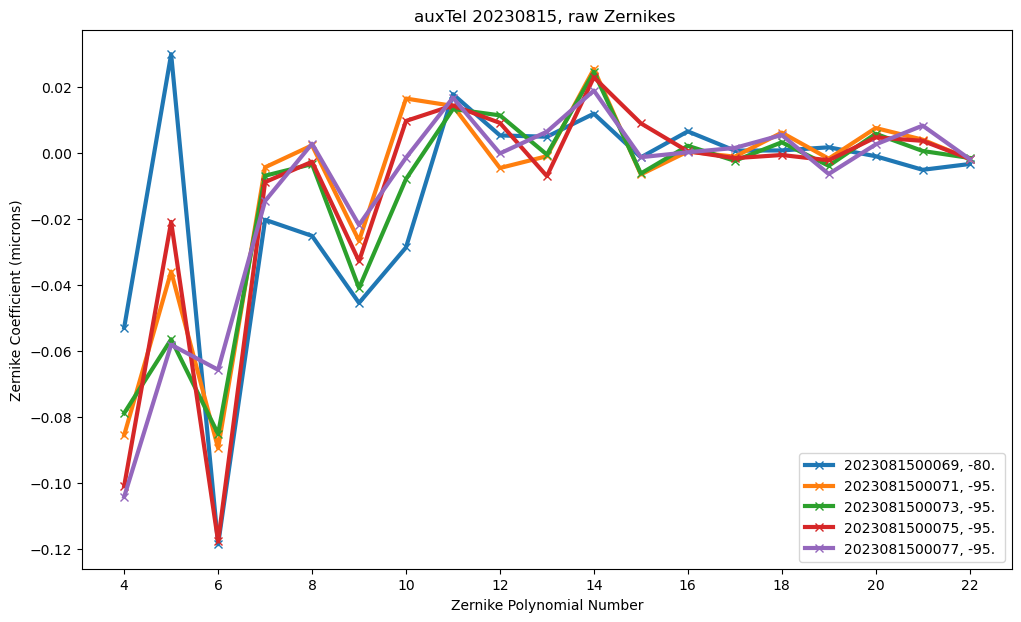

In [50]:
fig,ax = plt.subplots(1,1,figsize=(12,7))

for expId in extra_ids:
    # angle = rot - el 
    # elevation doesn't change much
    # rot is 0.23 for first pair, and then shifted by 15 degrees. 
    m = d['extraId'] == expId
    angle = str(d['angle'][m].value[0])[:4]
    ax.plot(np.arange(4,23), zks[expId][0], '-x', lw=3, label=f'{expId}, {angle} ')

ax.legend()
ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Zernike Polynomial Number')
ax.set_ylabel('Zernike Coefficient (microns)')
ax.set_title(f'auxTel 20230815, raw Zernikes ')

So as we'd expect, there's a large difference between blue (angle -80) and other (angle -95), especially in zk4, zk5 

zk5: oblique astigmatism
zk6: vertical astigmatism 
zk7 : comaX
zk8: comaY


Apply appropriate derotation:

In [41]:
from galsim.zernike import zernikeRotMatrix
zks_rot = {}
add_angle=0
mult_angle = -1
for expId in extra_ids:
    # first, pad with 4 zeros so that array[N]  corresponds to ZkN
    zk4_22 = zks[expId][0]
    zk1_22 = np.pad(zk4_22,[4,0])

    # now derotate using the  
    # EFD angle = el-rot 
    #           = Nasmyth2CalculatedAngle- elevationCalculatedAngle
    m = d['extraId'] == expId
    angle = d['angle'][m].value[0]   
    zk1_22rot = np.matmul(zk1_22, 
                          zernikeRotMatrix(22, np.deg2rad(add_angle+mult_angle*angle)))
    zks_rot[expId] = zk1_22rot
     

In [47]:
len(zk1_22rot[4:22])

18

Text(0.5, 1.0, 'auxTel 20230815, derotated Zernikes')

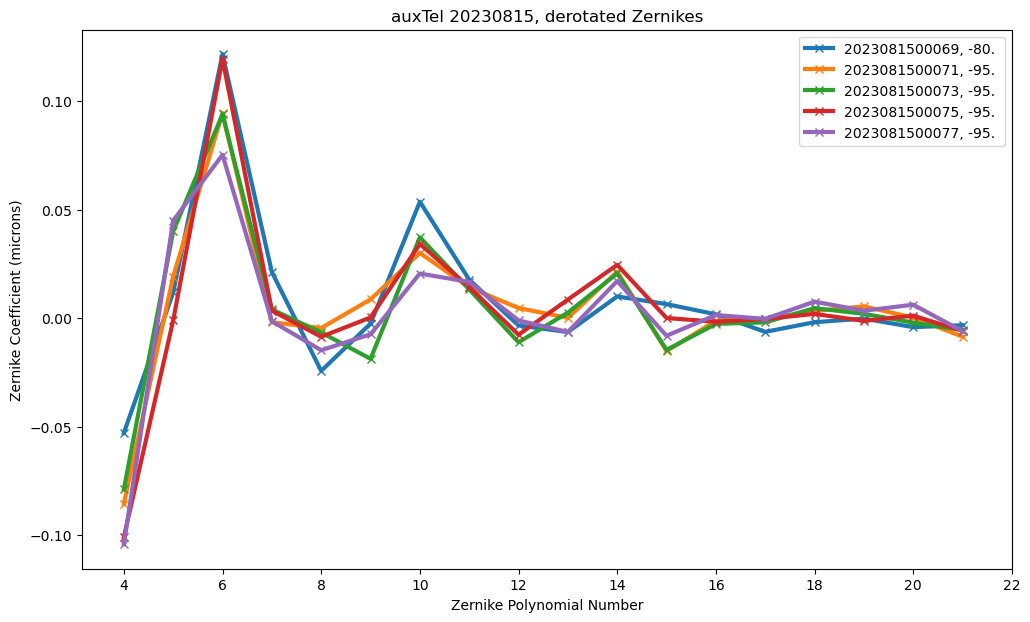

In [49]:
fig,ax = plt.subplots(1,1,figsize=(12,7))

for expId in extra_ids:
    # angle = rot - el 
    # elevation doesn't change much
    # rot is 0.23 for first pair, and then shifted by 15 degrees. 
    m = d['extraId'] == expId
    angle = str(d['angle'][m].value[0])[:4]
    ax.plot(np.arange(4,22), zks_rot[expId][4:22], '-x', lw=3, label=f'{expId}, {angle} ')

ax.legend()
ax.set_xticks(range(4,24)[::2])
ax.set_xlabel('Zernike Polynomial Number')
ax.set_ylabel('Zernike Coefficient (microns)')
ax.set_title(f'auxTel 20230815, derotated Zernikes')

So after derotation all are pretty much identical ! Which means that they have been correctly derotated.